In [1]:
import pandas as pd
import numpy as np

import utils as u

import pickle
import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline

# vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# feature selectors
from sklearn.feature_selection import SelectKBest, chi2

# scalers
from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

# samplers
from imblearn.under_sampling import TomekLinks

# calibration
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df = pd.read_pickle('../pandas/lemma_delivered_merged_df.pkl')

In [3]:
#df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_labeled_vocab.pkl')
df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_full_vocab.pkl')
df['is_nn'] = pd.read_pickle('../pandas/is_nn_full.pkl')
df['is_trash'] = pd.read_pickle('../pandas/is_trash_full.pkl')

In [4]:
labeled_corpus = df[(df['agg_label'] != -1) & (df['is_nn'] == False)]
unlabeled_corpus = df[(df['agg_label'] == -1) & (df['is_nn'] == False) & (df['is_trash'] == False)]

target = 'agg_label'
text = 'lemma_delivered'
fasttext = 'ft'
numeric = ['raw_len', 'raw_word_count']

In [5]:
train_X, vali_X, train_y, vali_y = train_test_split(
    labeled_corpus,
    labeled_corpus[target],
    test_size=0.4,
    random_state=1,
    stratify=labeled_corpus[target])

test_X, validation_X, test_y, validation_y = train_test_split(
    vali_X,
    vali_y,
    test_size=0.5,
    random_state=1,
    stratify=vali_y)

In [6]:
class FastTextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        return np.stack(df[self.col].to_numpy())

def modeller(data, feats, vectorizer, scaler, selector, sampler, classifier):

    features = []

    if 'text' in feats:
        features.append(
            ('text', Pipeline([
                ('article', u.ColumnSelector(feats['text'])),
                ('vectorizer', vectorizer['vec'](**vectorizer['params'])),
                #('selector', selector['sel'](**selector['params'])),
            ]))
        )

    if 'numeric' in feats:
        features.append(
            ('numerical', Pipeline([
                ('numeric', u.ColumnSelector(feats['numeric'])),
                ('scaler', scaler['sca'](**scaler['params'])),
            ]))
        )

    if 'ft' in feats:
        features.append(
            ('embeddings', Pipeline([
                ('ft', FastTextSelector(feats['ft'])),
                ('scaler', scaler['sca'](**scaler['params'])),
            ]))
        )

    model = Pipeline([
        ('features', FeatureUnion(features)),
        #('selector', selector['sel'](**selector['params'])),
        ('sampler', sampler['smpl'](**sampler['params'])),
        #('scaler', scaler['sca'](**scaler['params'])),
        ('classifier', classifier['clf'](**classifier['params']))
    ])
    

    model.fit(data['train_X'], data['train_y'])
    preds = model.predict(data['validation_X'])
    probs = model.predict_proba(data['validation_X'])
    
    metrics = {}
    
    if 'validation_y' in data:
        metrics['acc'] = accuracy_score(data['validation_y'], preds)
        metrics['prec'], metrics['reca'], metrics['fsco'], _ = precision_recall_fscore_support(data['validation_y'], preds, average='macro')
        #print(acc, prec, reca, fsco)
    
    return preds, probs, metrics

In [7]:
# feature combinations
feats = [
    #('TextOnly', {'text': text}),
    #('FTOnly', {'ft': fasttext}),
    ('Text+FT', {'text': text, 'ft': fasttext}),
    #('Text+DLWC', {'text': text, 'numeric': numeric}),
    #('All', {'text': text, 'numeric': numeric, 'ft': fasttext}),
]


# vectorizers
vectorizers = [
    #('No_vectorizer', u.PassThrough, [{}]),
    ('TfidfVectorizer', TfidfVectorizer, [{'lowercase': False, 'max_df': 0.25}]),  
]

#corpus = ['empty']
#fastt = False

# feature selectors
selectors = [
    ('No_selector', u.PassThrough, [{}]),
    #('SelectKBest', SelectKBest, [{'score_func': chi2, 'k': 40000}]),
]

# scalers
scalers = [
    #('No_scaling', u.PassThrough, [{}]),
    ('MinMaxScaler', MinMaxScaler, [{'feature_range': (0,1)}]),
]

# classifiers

clf = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01})

classifiers = [
    #('LinearSVC', LinearSVC, [{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}]),
    ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, [{'base_estimator': clf, 'method': 'isotonic', 'cv': 3}]),
]

# samplers
samplers = [
    #('No_sampling', u.PassThrough, [{}]),
    ('TomekLinks', TomekLinks, [{'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}]),
]


def model_caller(data):
  
    preds, probs, metrics = modeller(**{
        'data': data,
        'feats': feats[0][1],
        'vectorizer': {
            'vec': vectorizers[0][1],
            'params': vectorizers[0][2][0]
        },
        'scaler': {
            'sca': scalers[0][1],
            'params': scalers[0][2][0]
        },
        'selector': {
            'sel': selectors[0][1],
            'params': selectors[0][2][0]
        },
        'sampler': {
            'smpl': samplers[0][1],
            'params': samplers[0][2][0]
        },
        'classifier': {
            'clf': classifiers[0][1],
            'params': classifiers[0][2][0]
        }
    })
    
    model_title = {
        'features': feats[0][0],
        'vectorizer': vectorizers[0][0],
        'scaler': scalers[0][0],
        'selector': selectors[0][0],
        'sampler': samplers[0][0],
        'classifier': classifiers[0][0],
    }
    
    print(model_title)
    return preds, probs, metrics

In [ ]:
results, preds_validation = u.model_iterator({
    'train_X': train_X,
    'train_y': train_y,
    'validation_X': validation_X,
    'validation_y': validation_y,
    #'validation_X': test_X,
    #'validation_y': test_y
}, feats, vectorizers, classifiers, samplers, selectors, scalers)

display(results.sort_values(by=['Accuracy', 'Precision'], ascending=False))

In [28]:
data_vali = {
    'train_X': train_X,
    'train_y': train_y,
    'validation_X': test_X,
    'validation_y': test_y,
}

preds, _, metrics = model_caller(data_vali)

print(metrics)

{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
{'acc': 0.7119667292728736, 'prec': 0.7028983512507218, 'reca': 0.6742390758453631, 'fsco': 0.6848096242250977}


(27, 27)


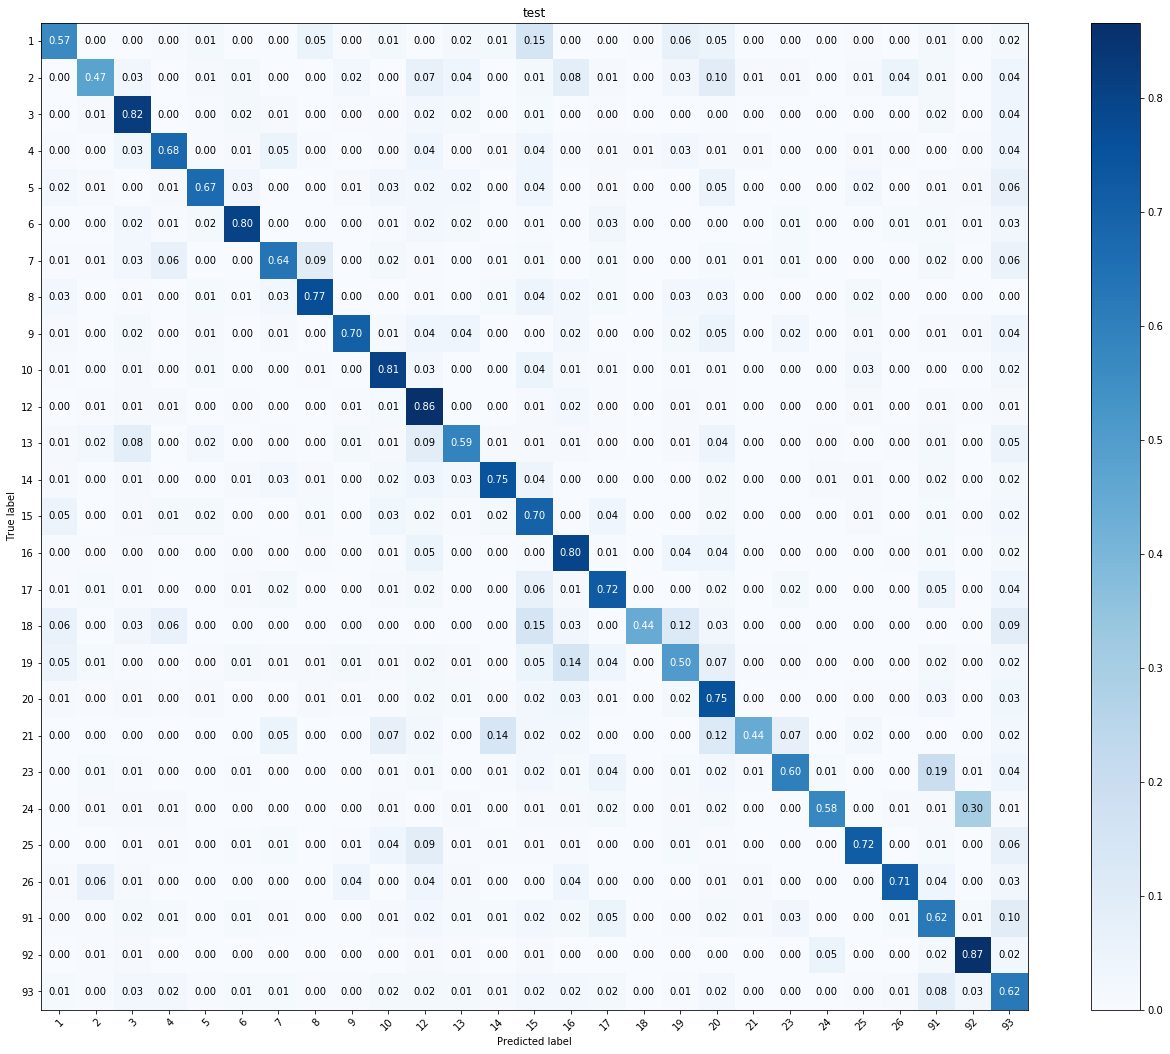

In [29]:
testy = u.plot_cf(test_y, preds, title = 'test')

In [8]:
def basic_wrapper(iterations=10, sample_size=1000, threshold=0.9, vali=False):

    sampled_indexes = pd.Index([])

    iter_data = [
        train_X.copy(),
        train_y.copy()
    ]

    iter_preds = []
    iter_metrics = []
    
    iter_acc = vali

    for i in range(iterations):

        print("Iteration: " + str(i+1))

        if sample_size != False:
            sample = unlabeled_corpus.drop(labels=sampled_indexes).sample(n=sample_size, random_state=i)
        else:
            sample = unlabeled_corpus.drop(labels=sampled_indexes)

        data_sample = {
            'train_X': iter_data[0],
            'train_y': iter_data[1],
            'validation_X': sample
        }

        preds, probs, _ = model_caller(data_sample)

        sample['preds'] = preds
        sample['probs'] = np.amax(probs, axis=1)

        mask = sample['probs'] > threshold
        
        if mask.sum() > 0:
            
            
            if vali != False:
                
                data_vali = {
                    'train_X': pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1).loc[mask]]),
                    'train_y': iter_data[1].append(sample.loc[mask]['preds']),
                    'validation_X': validation_X,
                    'validation_y': validation_y,
                }

                preds, _, metrics = model_caller(data_vali)

                iter_preds.append(preds)
                iter_metrics.append(metrics)

                print(metrics)
                
                if metrics['acc'] > iter_acc:
                    
                    iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1).loc[mask]])
                    iter_data[1] = iter_data[1].append(sample.loc[mask]['preds'])

                    sampled_indexes = sampled_indexes.union(sample.loc[mask].index)
                    
                    iter_acc = metrics['acc']
                    
                    print("New accuracy: " + str(iter_acc) + " Increase performance: " + str(int(vali / iter_acc * 100)) + "%")
                
            else:

                iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1).loc[mask]])
                iter_data[1] = iter_data[1].append(sample.loc[mask]['preds'])

                sampled_indexes = sampled_indexes.union(sample.loc[mask].index)

            print("Total number of unlabeled added: " + str(sampled_indexes.shape[0]))
            
        else:
            print("No new samples!")
            if sample_size == False:
                break

    
    data_test = {
        'train_X': iter_data[0],
        'train_y': iter_data[1],
        'validation_X': test_X,
        'validation_y': test_y,
    }

    test_preds, _, test_metrics = model_caller(data_test)
    
    return sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics
    

In [13]:
grid_result = pd.DataFrame([], columns=[
    'Sample_size',
    'Iterations',
    'Confidence',
    'Samples_added',
    'Accuracy',
    'Precision',
    'Recall',
    'Fscore'])

grid_preds = {}

grid_distro = {}

for iterat in [5, 10, 15]:
    for sample_s in [50000, 100000, 150000]:
        for thresh in [0.99, 0.98]:
            
            run_title = str(iterat) + "_" + str(sample_s) + "_" + str(thresh)
            
            print(run_title)
            
            sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics = basic_wrapper(iterations=iterat, sample_size=sample_s, threshold=thresh)
            
            grid_preds[run_title] = test_preds
            
            grid_distro[run_title] = (iter_data[1].value_counts() - train_y.value_counts())
            
            print(test_metrics)
            
            grid_result = grid_result.append(pd.Series({
                'Sample_size': sample_s,
                'Iterations': iterat,
                'Confidence': thresh,
                'Samples_added': sampled_indexes.shape[0],
                'Accuracy': test_metrics['acc'],
                'Precision': test_metrics['prec'],
                'Recall': test_metrics['reca'],
                'Fscore': test_metrics['fsco']
            }, name=run_title))

display(grid_result.sort_values(by=['Accuracy', 'Precision'], ascending=False))

5_50000_0.99
Iteration: 1
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 120
Iteration: 2
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 257
Iteration: 3
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 373
Iteration: 4
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 471
Iteration: 5
{'features': 'Text+FT', 'vectorize

C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\nils\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 6292
Iteration: 8
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 6669
Iteration: 9
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 6939
Iteration: 10
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 7154
Iteration: 11
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer

,Sample_size,Iterations,Confidence,Samples_added,Accuracy,Precision,Recall,Fscore
10_50000_0.99,50000.0,10.0,0.99,948.0,0.713308,0.704759,0.677057,0.687304
5_150000_0.99,150000.0,5.0,0.99,1267.0,0.712503,0.703222,0.676989,0.686511
5_100000_0.99,100000.0,5.0,0.99,956.0,0.712369,0.702629,0.676158,0.685981
15_50000_0.99,50000.0,15.0,0.99,1232.0,0.711833,0.703360,0.676149,0.686080
5_50000_0.99,50000.0,5.0,0.99,562.0,0.711833,0.701530,0.673298,0.683606
10_100000_0.99,100000.0,10.0,0.99,1458.0,0.711698,0.703469,0.676592,0.686320
10_50000_0.98,50000.0,10.0,0.98,3942.0,0.709954,0.695374,0.680504,0.685175
5_100000_0.98,100000.0,5.0,0.98,3924.0,0.709820,0.697486,0.681450,0.686704
10_150000_0.99,150000.0,10.0,0.99,1722.0,0.707942,0.696699,0.677182,0.683617
15_100000_0.99,100000.0,15.0,0.99,1697.0,0.707674,0.697029,0.676767,0.683506


In [14]:
result = {
    'grid_result': grid_result,
    'grid_preds': grid_preds,
    'grid_distro': grid_distro
}

timestamp = str(round(time.time()))
with open('../stats/'+timestamp+'_basic_wrapper_sample_data_trash_filter_results.pkl', 'wb') as f:
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

In [18]:
grid_distro['15_150000_0.98']

1        0
2        0
3      985
4       15
5        0
6      247
7        5
8      293
9       34
10     443
12    4811
13       3
14       6
15      53
16     748
17      38
18       0
19       0
20      43
21       0
23       3
24       1
25       9
26       0
91       0
92       0
93       0
dtype: int64

In [9]:
#sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics = basic_wrapper(iterations=5, sample_size=50000, threshold=0.99, vali=0.7038)
sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics = basic_wrapper(iterations=5, sample_size=50000, threshold=0.99)

Iteration: 1
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 120
Iteration: 2
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 258
Iteration: 3
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 374
Iteration: 4
{'features': 'Text+FT', 'vectorizer': 'TfidfVectorizer', 'scaler': 'MinMaxScaler', 'selector': 'No_selector', 'sampler': 'TomekLinks', 'classifier': 'CalibratedClassifierCV_LinearSVC'}
Total number of unlabeled added: 474
Iteration: 5
{'features': 'Text+FT', 'vectorizer': 'TfidfVec

In [10]:
test_metrics

{'acc': 0.713710759323853,
 'prec': 0.7051967907749896,
 'reca': 0.6754566189348743,
 'fsco': 0.686519832241747}

(27, 27)


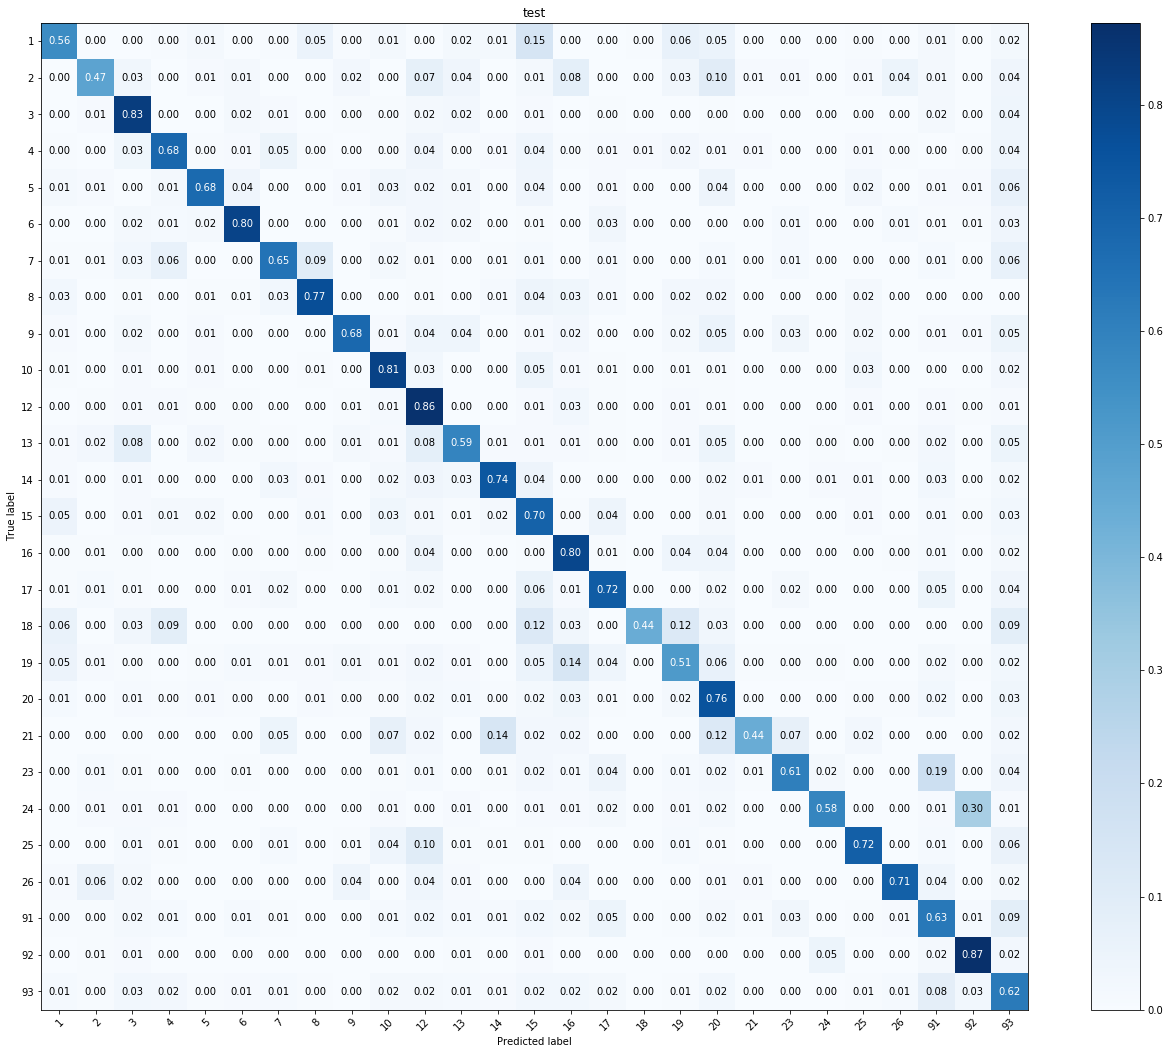

In [11]:
testy = u.plot_cf(test_y, test_preds, title = 'test')

In [12]:
(iter_data[1].value_counts() - train_y.value_counts())

1       0
2       0
3      53
4       0
5       0
6       5
7       0
8      15
9       1
10     30
12    411
13      0
14      0
15      0
16     52
17      0
18      0
19      0
20      0
21      0
23      0
24      0
25      0
26      0
91      0
92      0
93      0
dtype: int64

In [30]:
result = {
    'sampled_indexes': sampled_indexes,
    'iter_data': iter_data,
    'iter_preds': iter_preds,
    'iter_metrics': iter_metrics,
    'test_preds': test_preds,
    'test_metrics': test_metrics
}

timestamp = str(round(time.time()))
with open('../stats/'+timestamp+'_basic_wrapper_all_data_results.pkl', 'wb') as f:
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
sum(preds_validation['preds'][0] == -1)

In [ ]:
acc, preds, probs = basic_wrapper(train_X, train_y, validation_X, validation_y, model)

In [27]:
labeled_corpus.loc[labeled_corpus[target] == 92][text].sample(1).tolist()

['tjene HAUGEVIS $. un $: selge verden dyr forsvare In $: Rune Hauge tjene seg ikke bare rik på norsk overgang $. i går være han en av mann bak salge av verden dyr forsvarsspille $. Hauge lure i kulisse da Rio Ferdinand gå fra West han til Leed for 237 million krone $. og bare siden i fjor sommer ha Hauge stå bak internasjonal overgang $, uten nordmann $, til en verdi av liten 411 million krone $. ingen kommentar $, si Hauge til VG i går ettermiddag $. men VG vite at vossing $, sammen med israelsk Pinha Zahavi og engelskmann Barry Silkman $, de sist dag ha jobbe for å få West Ham-forsvarer Rio Ferdinand klar for Leed i en historisk overgang verdt 237 million krone $. vanligvis motta agent mellom fem og ti prosent av overgangssum til fordeling seg imellom $. hvis tre agent skulle fordele 10 prosent av Ferdinand overgangssum $, kunne Hauge sitte igjen med så mye som åtte million krone av overgangspeng $. VG vite også at Hauge i fjor selge tyske Dietmar Hamann fra Newcastle til Liverpool 

In [9]:
def quick_model(t_X, t_y, v_X):
    vec = TfidfVectorizer(**{'lowercase': False, 'max_df': 0.25}) 
    vec_t_X = vec.fit_transform(t_X)
    vec_v_X = vec.transform(v_X)
    #vec_test_X = vec.transform(test_X[text])

    clf = ComplementNB(**{'alpha': 0.2})
    #clf.fit(vec_t_X, t_y)
    
    calibrator = CalibratedClassifierCV(clf, cv=3)
    calibrator.fit(vec_t_X, t_y)

    preds = calibrator.predict(vec_v_X)
    probs = calibrator.predict_proba(vec_v_X)
    
    return preds, probs

def basic_wrapper_with_validation(iterations=10, sample_size=1000, threshold=0.9):

    sampled_indexes = pd.Index([])

    iter_data = [
        train_X.copy(),
        train_y.copy()
    ]

    iter_preds = []
    iter_metrics = []

    init_vali_preds, _ = quick_model(iter_data[0][text], iter_data[1], validation_X[text])
    init_acc = accuracy_score(validation_y, init_vali_preds)
    iter_acc = init_acc
    
    print("Initial validation accuracy: " + str(init_acc))

    for i in range(iterations):

        print("Iteration: " + str(i+1))

        if sample_size != False:
            sample = unlabeled_corpus.drop(labels=sampled_indexes).sample(n=sample_size, random_state=i)
        else:
            sample = unlabeled_corpus.drop(labels=sampled_indexes)
            
        preds, probs = quick_model(iter_data[0][text], iter_data[1], sample[text])

        sample['preds'] = preds
        sample['probs'] = np.amax(probs, axis=1)

        mask = sample['probs'] > threshold
        
        print("Number of candidates: " + str(mask.sum()))
        
        if mask.sum() > 0:

            t_X = pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1).loc[mask]])
            t_y = iter_data[1].append(sample.loc[mask]['preds'])
            vali_preds, _ = quick_model(t_X[text], t_y, validation_X[text])
            vali_acc = accuracy_score(validation_y, vali_preds)

            iter_preds.append(preds)
            iter_metrics.append(vali_acc)

            print("Validation accuracy: " + str(vali_acc))

            if vali_acc > iter_acc:

                iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1).loc[mask]])
                iter_data[1] = iter_data[1].append(sample.loc[mask]['preds'])

                sampled_indexes = sampled_indexes.union(sample.loc[mask].index)

                iter_acc = vali_acc

                print("New accuracy: " + str(iter_acc) + " Increase performance: " + str(int(((iter_acc / init_acc) - 1) * 100)) + "%")

            print("Total number of unlabeled added: " + str(sampled_indexes.shape[0]))
            
        else:
            print("No new samples!")
            if sample_size == False:
                break

    
    data_test = {
        'train_X': iter_data[0],
        'train_y': iter_data[1],
        'validation_X': test_X,
        'validation_y': test_y,
    }

    test_preds, _, test_metrics = model_caller(data_test)
    
    return sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics

In [16]:
sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics = basic_wrapper_with_validation(iterations=150, sample_size=50000, threshold=0.97)

Initial validation accuracy: 0.6598256203890007
Iteration: 1
Number of candidates: 21
Validation accuracy: 0.6599597585513078
New accuracy: 0.6599597585513078 Increase performance: 0%
Total number of unlabeled added: 21
Iteration: 2
Number of candidates: 30
Validation accuracy: 0.6594232059020791
Total number of unlabeled added: 21
Iteration: 3
Number of candidates: 19
Validation accuracy: 0.6598256203890007
Total number of unlabeled added: 21
Iteration: 4
Number of candidates: 26
Validation accuracy: 0.6600938967136151
New accuracy: 0.6600938967136151 Increase performance: 0%
Total number of unlabeled added: 47
Iteration: 5
Number of candidates: 24
Validation accuracy: 0.6596914822266935
Total number of unlabeled added: 47
Iteration: 6
Number of candidates: 24
Validation accuracy: 0.6600938967136151
Total number of unlabeled added: 47
Iteration: 7
Number of candidates: 32
Validation accuracy: 0.6599597585513078
Total number of unlabeled added: 47
Iteration: 8
Number of candidates: 36


In [18]:
test_metrics

{'acc': 0.7110276361685002,
 'prec': 0.7027351481887769,
 'reca': 0.6728652021054528,
 'fsco': 0.6838996289483618}

In [19]:
(iter_data[1].value_counts() - train_y.value_counts())

12    65
93     0
91     0
15     0
16     0
20     0
3      0
10     0
92     7
17     0
19     0
4      0
13     0
1      0
23     0
8      0
6      0
7      0
25     0
5      0
2      0
9      0
24     0
14     0
26     0
21     0
18     0
dtype: int64

In [21]:
def basic_wrapper_with_validation_random_samples(iterations=10, sample_size=40):

    sampled_indexes = pd.Index([])

    iter_data = [
        train_X.copy(),
        train_y.copy()
    ]

    iter_preds = []
    iter_metrics = []

    init_vali_preds, _ = quick_model(iter_data[0][text], iter_data[1], validation_X[text])
    init_acc = accuracy_score(validation_y, init_vali_preds)
    iter_acc = init_acc
    
    print("Initial validation accuracy: " + str(init_acc))

    for i in range(iterations):

        print("Iteration: " + str(i+1))

        sample = unlabeled_corpus.drop(labels=sampled_indexes).sample(n=sample_size, random_state=i)

        preds, probs = quick_model(iter_data[0][text], iter_data[1], sample[text])

        sample['preds'] = preds
        sample['probs'] = np.amax(probs, axis=1)

        t_X = pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1)])
        t_y = iter_data[1].append(sample['preds'])
        vali_preds, _ = quick_model(t_X[text], t_y, validation_X[text])
        vali_acc = accuracy_score(validation_y, vali_preds)

        iter_preds.append(preds)
        iter_metrics.append(vali_acc)

        print("Validation accuracy: " + str(vali_acc))

        if vali_acc > iter_acc:

            iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds', 'probs'], axis=1)])
            iter_data[1] = iter_data[1].append(sample['preds'])

            sampled_indexes = sampled_indexes.union(sample.index)

            iter_acc = vali_acc

            print("New accuracy: " + str(iter_acc) + " Increase performance: " + str(int(((iter_acc / init_acc) - 1) * 100)) + "%")

        print("Total number of unlabeled added: " + str(sampled_indexes.shape[0]))


    
    data_test = {
        'train_X': iter_data[0],
        'train_y': iter_data[1],
        'validation_X': test_X,
        'validation_y': test_y,
    }

    test_preds, _, test_metrics = model_caller(data_test)
    
    return sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics

In [25]:
sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics = basic_wrapper_with_validation_random_samples(iterations=150, sample_size=30)

Initial validation accuracy: 0.6598256203890007
Iteration: 1
Validation accuracy: 0.6602280348759222
New accuracy: 0.6602280348759222 Increase performance: 0%
Total number of unlabeled added: 30
Iteration: 2
Validation accuracy: 0.6607645875251509
New accuracy: 0.6607645875251509 Increase performance: 0%
Total number of unlabeled added: 60
Iteration: 3
Validation accuracy: 0.6604963112005365
Total number of unlabeled added: 60
Iteration: 4
Validation accuracy: 0.6607645875251509
Total number of unlabeled added: 60
Iteration: 5
Validation accuracy: 0.6604963112005365
Total number of unlabeled added: 60
Iteration: 6
Validation accuracy: 0.6604963112005365
Total number of unlabeled added: 60
Iteration: 7
Validation accuracy: 0.6600938967136151
Total number of unlabeled added: 60
Iteration: 8
Validation accuracy: 0.6603621730382294
Total number of unlabeled added: 60
Iteration: 9
Validation accuracy: 0.6602280348759222
Total number of unlabeled added: 60
Iteration: 10
Validation accuracy: 

In [32]:
test_metrics

{'acc': 0.7110276361685002,
 'prec': 0.7027811501317163,
 'reca': 0.6730671683774032,
 'fsco': 0.6840505952592527}

In [35]:
(iter_data[1].value_counts() - train_y.value_counts())

1      8
2      8
3     16
4      9
5      2
6      4
7      4
8      3
9      5
10     7
12    39
13     7
14     3
15    12
16    10
17     9
18     2
19    10
20    16
21     3
23     5
24     8
25     3
26     4
91    79
92    76
93    68
dtype: int64

(27, 27)


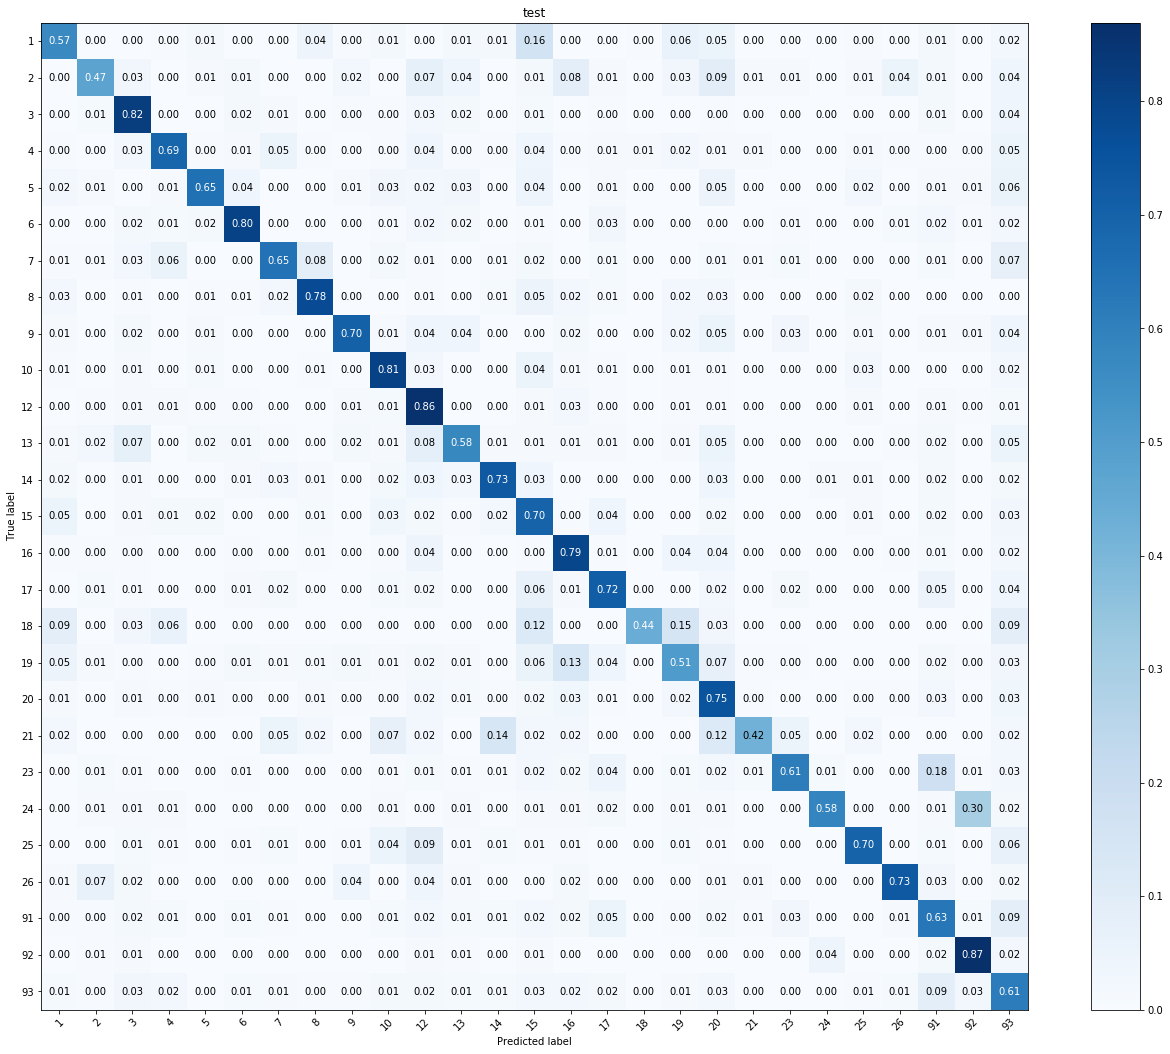

In [36]:
testy = u.plot_cf(test_y, test_preds, title = 'test')

In [37]:
sampled_indexes, iter_data, iter_preds, iter_metrics, test_preds, test_metrics = basic_wrapper_with_validation_random_samples(iterations=300, sample_size=30)

Initial validation accuracy: 0.6598256203890007
Iteration: 1
Validation accuracy: 0.6602280348759222
New accuracy: 0.6602280348759222 Increase performance: 0%
Total number of unlabeled added: 30
Iteration: 2
Validation accuracy: 0.6607645875251509
New accuracy: 0.6607645875251509 Increase performance: 0%
Total number of unlabeled added: 60
Iteration: 3
Validation accuracy: 0.6604963112005365
Total number of unlabeled added: 60
Iteration: 4
Validation accuracy: 0.6607645875251509
Total number of unlabeled added: 60
Iteration: 5
Validation accuracy: 0.6604963112005365
Total number of unlabeled added: 60
Iteration: 6
Validation accuracy: 0.6604963112005365
Total number of unlabeled added: 60
Iteration: 7
Validation accuracy: 0.6600938967136151
Total number of unlabeled added: 60
Iteration: 8
Validation accuracy: 0.6603621730382294
Total number of unlabeled added: 60
Iteration: 9
Validation accuracy: 0.6602280348759222
Total number of unlabeled added: 60
Iteration: 10
Validation accuracy: 

In [41]:
test_metrics

{'acc': 0.711832573115106,
 'prec': 0.7035600344192388,
 'reca': 0.6733445435632107,
 'fsco': 0.6846664867204463}

In [39]:
(iter_data[1].value_counts() - train_y.value_counts())

1      8
2      9
3     16
4     10
5      2
6      5
7      4
8      3
9      5
10     8
12    42
13     7
14     3
15    14
16    12
17     9
18     2
19    10
20    18
21     3
23     6
24     8
25     3
26     4
91    84
92    82
93    73
dtype: int64

(27, 27)


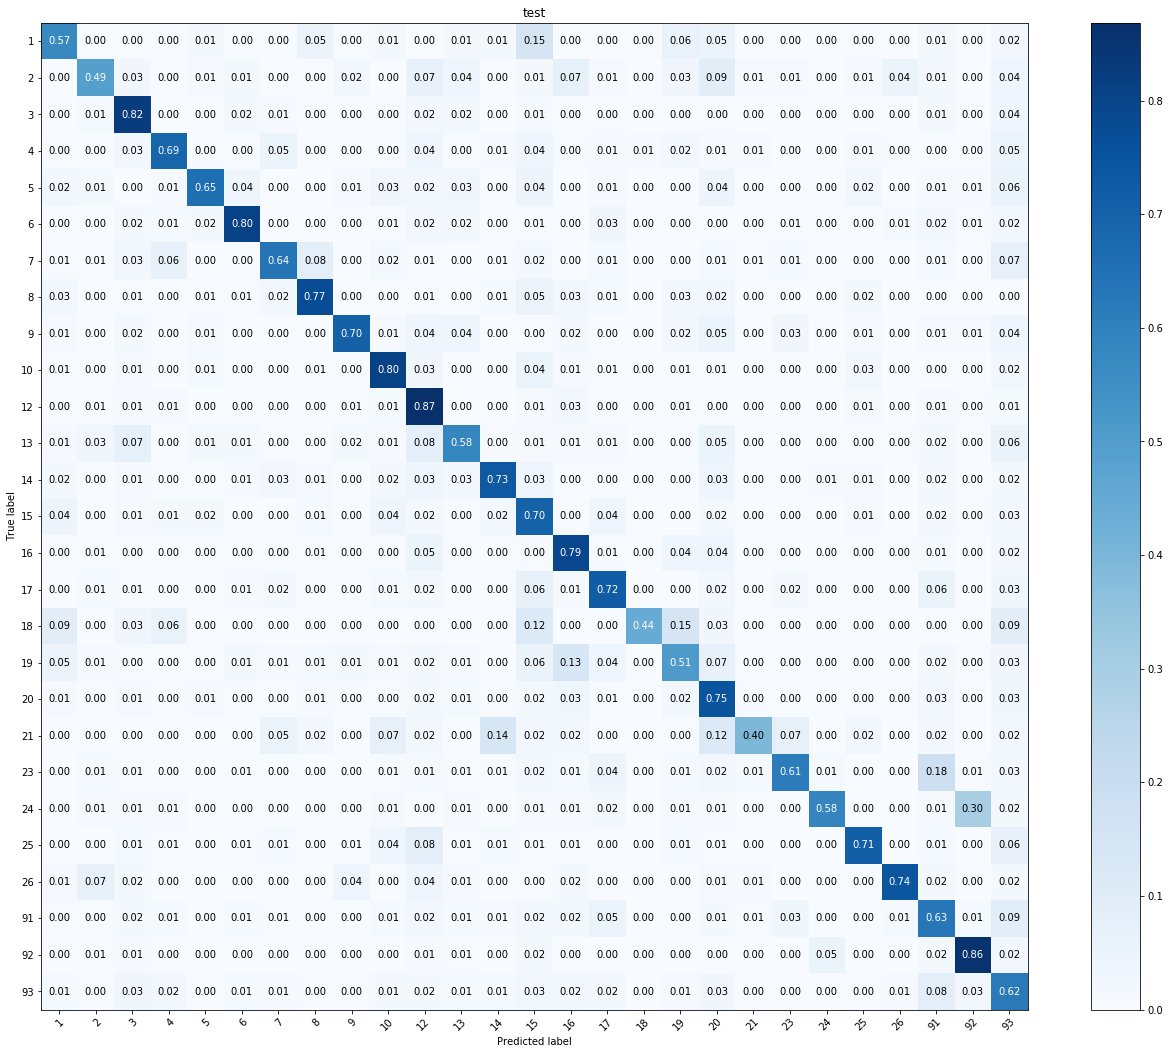

In [40]:
testy = u.plot_cf(test_y, test_preds, title = 'test')

In [10]:
unlab_preds, unlab_probs = quick_model(train_X[text], train_y, unlabeled_corpus[text])

In [26]:
unlab_preds_unique, unlab_preds_counts = np.unique(unlab_preds, return_counts=True)
unlab_distro_df = pd.DataFrame(zip(unlab_preds_unique, unlab_preds_counts), columns=['Pseudo-label', 'Counts'])

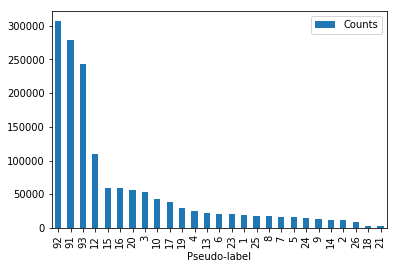

In [27]:
unlab_distro_df.set_index('Pseudo-label').sort_values('Counts', ascending=False).plot.bar()